In [2]:
# 1: Import Library
import tensorflow as tf
import numpy as np
import glob
import os

In [3]:
# 2: โหลดโมเดล ResNet
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, pooling='avg')

In [116]:
# 3: กำหนดตำแหน่งของ Dataset

dataset_path = './dataset'
train_dataset_path = os.path.join(dataset_path, 'train')

In [117]:
# 4: โหลดและเตรียมรูปภาพจาก Dataset สำหรับการ Embedding

train_imgfolder_path = os.path.join(train_dataset_path, 'dog') #ชื่อโฟลเดอร์ที่ต้องการจะใช้ในการ Embedding

train_image_paths = glob.glob(os.path.join(train_imgfolder_path, '*.jpg'))

train_images = []
for image_path in train_image_paths:
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    train_images.append(image)

if len(train_images) > 0:
    train_images = np.vstack(train_images)
    print("Train Images Shape:", train_images.shape)
else:
    print("No images found in the specified paths.")

Train Images Shape: (100, 224, 224, 3)


In [118]:
# 5: ใช้โมเดล ResNet เพื่อ Embedding

train_features = model.predict(train_images)

4/4 [==============================] - 4s 821ms/step


In [119]:
# # Optional: บันทึก Vector เป็นไฟล์
# train_feature_file = 'train_features.npy'  # ชื่อไฟล์ที่ต้องการ
# np.save(train_feature_file, train_features)

# train_feature_file = 'train_features.npy' 

# # โหลด Vector จากไฟล์
# train_features = np.load(train_feature_file)

In [120]:
# แสดงรูปร่างของ Vector

print("Train Features Shape:", train_features.shape)

# แสดง Vector

print("Train Features:")
print(train_features)

Train Features Shape: (100, 2048)
Train Features:
[[0.56924284 0.4844851  0.03184289 ... 0.         0.21779078 0.21020381]
 [0.1384156  0.14093679 0.13391925 ... 0.08402223 0.0964125  0.33219367]
 [0.09218282 0.5010484  0.13909869 ... 0.         0.64756954 0.5422662 ]
 ...
 [0.3563613  0.1471512  0.00473557 ... 0.8362866  0.33798155 0.        ]
 [0.38270453 2.1997988  0.07169923 ... 0.19955646 0.0175678  2.2605283 ]
 [1.0322127  1.0082858  0.03535103 ... 0.00329185 0.33946988 3.2070386 ]]


In [4]:
# ส่วนที่ 6: สร้าง Index ให้ Pinecone
from pinecone import Pinecone, PodSpec

pc = Pinecone(api_key="16699392-e679-41fd-84d0-0b14da31a412")

# new_index = pc.create_index(
#   name="animal-index",
#   dimension=2048,
#   metric="cosine",
#   spec=PodSpec(
#     environment="gcp-starter"
#   )
# )

# เรียกใช้ index

index = pc.Index("animal-index")

In [122]:
# ส่วนที่ 7: ใช้ upsert เพื่อเพิ่มหรืออัปเดตข้อมูลใน index

import uuid

data = [{'id': f'vector_{uuid.uuid4()}', 'values': train_features[i].tolist(), 'metadata': {'category': 'Dog'}} for i in range(len(train_features))] #ตรง metadata ให้กำหนดเป็นชื่อของสิ่งที่เทรนเช่น dog, cat etc.
index.upsert(data)

{'upserted_count': 100}

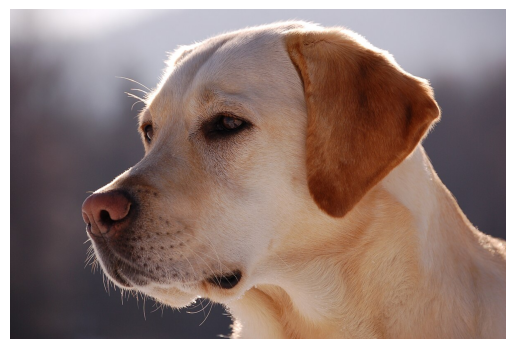

1/1 [==============================] - 0s 67ms/step
This image is similar to vector_94f8a3dd-4ca9-465a-b9e1-75e95e0ba86f
And I think this image must be :  {'category': 'Dog'}


{}

In [14]:
# ส่วนที่ 8: ทดสอบความคล้ายของรูปที่เตรียมมาเองกับใน Pinecone

from PIL import Image
import matplotlib.pyplot as plt

image_path = './testimg/dogtest4.jpg' #ตำแหน่งรูปที่ต้องการใช้ทดสอบ
image = Image.open(image_path)

plt.imshow(image)
plt.axis('off')
plt.show()

image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)
image = tf.keras.applications.resnet50.preprocess_input(image)
image_feature = model.predict(image)

data = [{'id': 'TestIMG', 'values': image_feature[0].tolist()}]
index.upsert(data)

query_vector = image_feature[0]
query_vector_list = query_vector.tolist()
results = index.query(vector=query_vector_list, top_k=1000, include_metadata=True)

filtered_results = [result for result in results['matches'] if result['id'] != 'TestIMG']

if len(filtered_results) > 0:
    highest_result = filtered_results[0]
    highest_result_id = highest_result['id']
    highest_result_metadata = highest_result['metadata']

    print('This image is similar to', highest_result_id)
    print('And I think this image must be : ', highest_result_metadata)
    
index.delete(ids=["TestIMG"])